Imports and model name

In [1]:
from transformers import AutoTokenizer

model_id = "gpt2"

e:\Downloads\Programs\conda\envs\GuidedNeuralChecker\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defining tokenizers

In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=False)
tokenizer_w_prefix_space = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True)

In [3]:
def decode_sequence(sequence, tokenizer):
    decoded_sequence = []
    for token in sequence:
        decoded_sequence.append(tokenizer.decode(token))
    return decoded_sequence

In [4]:
def test_tokenizers(string):
    print(f"String: {string}")
    encoded_string1 = tokenizer.encode(string)
    print(f"Encoded sequence while using tokenizer without prefix space: {encoded_string1}")
    print(f"Decoded sequence while using tokenizer without prefix space: {decode_sequence(encoded_string1, tokenizer)}")
    encoded_string2 = tokenizer_w_prefix_space.encode(string)
    print(f"Encoded sequence while using tokenizer without prefix space: {encoded_string2}")
    print(f"Decoded sequence while using tokenizer with prefix space: {decode_sequence(encoded_string2, tokenizer_w_prefix_space)}")

Testing with "medicine"

In [5]:
test_tokenizers("medicine")

String: medicine
Encoded sequence while using tokenizer without prefix space: [1150, 291, 500]
Decoded sequence while using tokenizer without prefix space: ['med', 'ic', 'ine']
Encoded sequence while using tokenizer without prefix space: [9007]
Decoded sequence while using tokenizer with prefix space: [' medicine']


Testing with "astrophysics"

In [6]:
test_tokenizers("astrophysics")

String: astrophysics
Encoded sequence while using tokenizer without prefix space: [459, 10051, 23154]
Decoded sequence while using tokenizer without prefix space: ['ast', 'roph', 'ysics']
Encoded sequence while using tokenizer without prefix space: [48782, 23154]
Decoded sequence while using tokenizer with prefix space: [' astroph', 'ysics']


Create Guide Models

In [7]:
from mini_relm_resources.automata_examples.small_study_example import get_small_study_example

guide_model = get_small_study_example(tokenizer.eos_token)

Load GPT-2 Model

In [8]:
import torch
from transformers import AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

In [9]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.small_study_example import alphabet

wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)
wrapper_w_prefix_space = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer_w_prefix_space)

In [10]:
from pythautomata.utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_generator = GuidingWDFASequenceGenerator(guide_model, None)

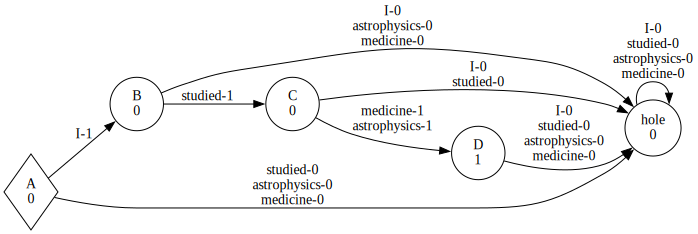

In [11]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guide_model)

display(graph)

In [12]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
from mini_relm_resources.automata_examples.small_study_example import get_small_study_example

property_model = get_small_study_example(wrapper.terminal_symbol)
property_model_w_prefix_space = get_small_study_example(wrapper_w_prefix_space.terminal_symbol)

syncrhronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_GPT2", max_seq_length=10, normalize_outputs=True, top_k=3)
syncrhronic_model_w_prefix_space = SyncronicModelGuidedLanguageModel(wrapper_w_prefix_space, property_model, model_name="GUIDED_GPT2", max_seq_length=10, normalize_outputs=True, top_k=3)

In [13]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from utilities.hypothesis_aware_sample_probabilistic_teacher import HypothesisAwareSampleProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import QuantizationProbabilityPartitionerPlus
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitionerPlus(1000)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 50
max_query_length = 50


In [14]:
teacher = HypothesisAwareSampleProbabilisticTeacher(syncrhronic_model, comparator, 30)
teacher_w_prefix_space = HypothesisAwareSampleProbabilisticTeacher(syncrhronic_model_w_prefix_space, comparator, 30)

In [15]:
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False, omit_zero_transitions=True)

In [16]:
learning_result = learner.learn(teacher, verbose=True)
learning_result_w_prefix_space = learner.learn(teacher_w_prefix_space, verbose=True)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


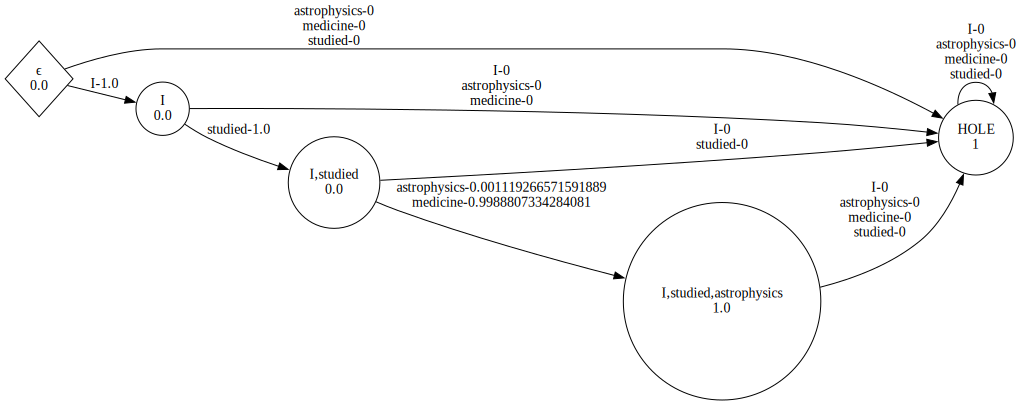

In [21]:
display(exporter.create_graph(learning_result.model))

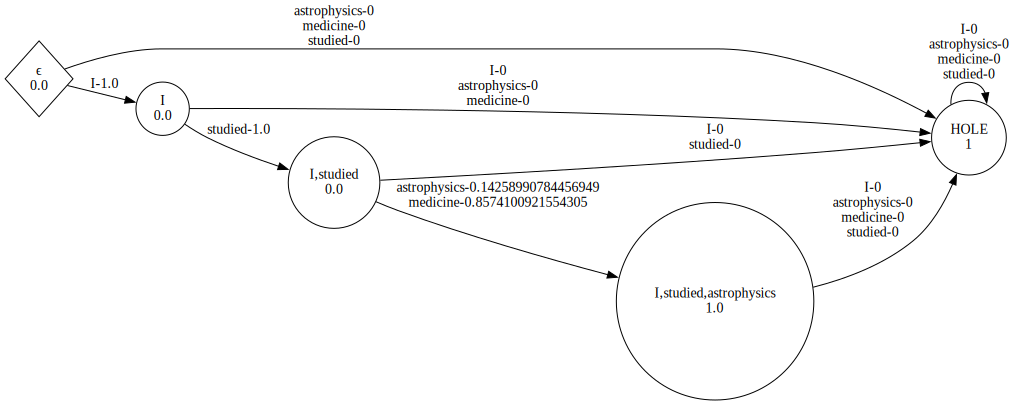

In [22]:
display(exporter.create_graph(learning_result_w_prefix_space.model))

EOS symbol with tokenizers

In [23]:
tokenizer.eos_token

'<|endoftext|>'

In [28]:
tokenizer.encode(tokenizer.eos_token, return_tensors="pt")

tensor([[50256]])

In [35]:
with torch.no_grad():
    next_token = torch.argmax(torch.softmax(model(tokenizer.encode(tokenizer.eos_token, return_tensors="pt")).logits, dim=-1))
next_token

tensor(0.0623, grad_fn=<MaxBackward1>)

In [34]:
tokenizer.decode(next_token)

'\n'

BOS as nex symbol with tokenizers

In [36]:
tokenizer.bos_token

'<|endoftext|>'

In [38]:
tokenizer.encode(tokenizer.bos_token, return_tensors="pt")

tensor([[50256]])

In [48]:
with torch.no_grad():
    next_token_probabilities = torch.softmax(model(tokenizer.encode("I", return_tensors="pt")).logits, dim=-1)[0][0]
    bos_probability = next_token_probabilities[tokenizer.bos_token_id] * 100
bos_probability

tensor(0.1286)